# <font color='red'>**Sequence to sequence implementation**</font>

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate model. 

In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import re
import warnings
warnings.filterwarnings('ignore')

<font color='blue'>**Load the data**</font>

In [2]:
import zipfile
with zipfile.ZipFile("ita-eng.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [2]:
files = os.listdir("data")
files

['ita.txt', '_about.txt']

<font color='blue'>**Preprocess data**</font>

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Activation,Dot,Add,Concatenate
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
with open('data/ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(354238, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [4]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [5]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

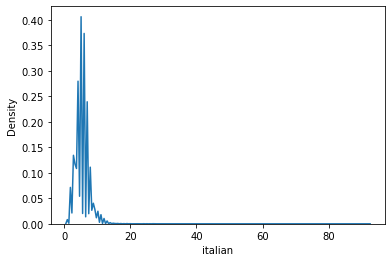

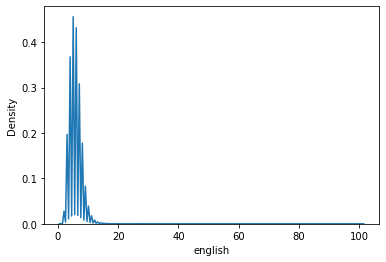

In [6]:
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

#### Note:
`we can see most of the sentences have length 20 words. so we will clip each sentences length below 20`

In [7]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [8]:
data.sample(10)

,italian,english_inp,english_out
227415,non riesci ad andare domattina,<start> can not you go tomorrow morning,can not you go tomorrow morning <end>
242256,non dimenticate di chiudere la porta,<start> do not forget to close the door,do not forget to close the door <end>
349867,cerano delle zebre nello zoo in cui sei andata...,<start> were there any zebras in the zoo you w...,were there any zebras in the zoo you went to l...
276013,perché vuoi tutte queste cose,<start> why do you want all these things,why do you want all these things <end>
16835,noi siamo affamati,<start> we are starved,we are starved <end>
166883,lui stava ascoltando la musica,<start> he was listening to music,he was listening to music <end>
83516,non abbiamo freni,<start> we have got no brakes,we have got no brakes <end>
207718,tom visse dal 1963 al 2013,<start> tom lived from 1963 to 2013,tom lived from 1963 to 2013 <end>
321834,ebbe una figlia dal suo primo marito,<start> she had a daughter by her first husband,she had a daughter by her first husband <end>
274797,tom è andato a boston a visitare mary,<start> tom went to boston to visit mary,tom went to boston to visit mary <end>


In [9]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [10]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(282996, 3) (70749, 3)


In [11]:
train.head()

,italian,english_inp,english_out
175500,tom è estremamente testardo,<start> tom is extremely stubborn <end>,tom is extremely stubborn <end> <end>
49981,io mi sento fortunato,<start> i am feeling lucky,i am feeling lucky <end>
273692,tom è meglio di me a cucinare,<start> tom is better at cooking than me,tom is better at cooking than me <end>
334586,odio le carote ancora di più di quanto odio le...,<start> i hate carrots even more than i hate o...,i hate carrots even more than i hate onions <end>
94259,provò a non urlare,<start> she tried not to cry,she tried not to cry <end>


In [ ]:
## Tokenize sentences excluding symbols < and >

In [13]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [14]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13085
26650


In [15]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10347)

### loading and batch dataset

In [16]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
# batch size = 256

In [17]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=256)
test_dataloader = Dataloder(test_dataset, batch_size=256)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(256, 20) (256, 20) (256, 20)


## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [18]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        
        super().__init__()
        
        self.lstm_size = lstm_size
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                                        name="embedding_layer_encoder")
        
        #Intialize Encoder LSTM layer
        self.lstm = LSTM(lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''

        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd, initial_state=states)
        
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

      
    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      return tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))


<font color='orange'>**Grader function - 1**</font>

In [19]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [20]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        
        super().__init__()
        
        #Initialize Embedding layer, we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, input_length=input_length,
                                        name="embedding_layer_decoder")
        
        #Intialize Decoder LSTM layer
        self.lstm = LSTM(lstm_size, return_sequences=True, return_state=True, name="Decoder_LSTM")


    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        
        target_embedd = self.embedding(input_sequence)
        lstm_output, decoder_state_h, decoder_state_c = self.lstm(target_embedd, initial_state=initial_states)
        
        return lstm_output, decoder_state_h, decoder_state_c

      


<font color='orange'>**Grader function - 2**</font>

In [21]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


In [22]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, vocab_size_ita, vocab_size_eng, embedding_dim, encoder_inputs_length,
                    decoder_inputs_length, lstm_units):
        
        super().__init__()
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=embedding_dim, input_length=encoder_inputs_length, lstm_size=lstm_units)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_size=embedding_dim, input_length=decoder_inputs_length, lstm_size=lstm_units)
        self.dense   = Dense(vocab_size_eng, activation='softmax')
    
    
    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
       
        encoder_input,decoder_input = data[0], data[1]
        enc_initial_states = self.encoder.initialize_states(tf.shape(encoder_input)[0])
        encoder_output, encoder_h, encoder_c = self.encoder(encoder_input, enc_initial_states)
        decoder_output, decoder_h, decoder_c = self.decoder(decoder_input, [encoder_h, encoder_c])
        output                               = self.dense(decoder_output)
        return output
        

In [23]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model  = Encoder_decoder(vocab_size_ita = vocab_size_ita, vocab_size_eng = vocab_size_eng, embedding_dim = 300, 
                           encoder_inputs_length = 20, decoder_inputs_length = 20, lstm_units = 256)

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

In [24]:
%load_ext tensorboard

In [25]:
import datetime

In [28]:
!rm -rf ./logs/enc-dec/

In [29]:
log_dir="logs/enc-dec/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [30]:
callbacks = [tensorboard_callback]

In [31]:
model.fit(train_dataloader, validation_data = test_dataloader, steps_per_epoch = len(train_dataloader), 
          epochs = 10, callbacks = callbacks)

Epoch 1/10
1105/1105 [==============================] - 198s 177ms/step - loss: 1.5925 - val_loss: 1.1446
Epoch 2/10
1105/1105 [==============================] - 57s 52ms/step - loss: 0.9027 - val_loss: 0.7091
Epoch 3/10
1105/1105 [==============================] - 60s 54ms/step - loss: 0.5558 - val_loss: 0.4675
Epoch 4/10
1105/1105 [==============================] - 61s 56ms/step - loss: 0.3590 - val_loss: 0.3425
Epoch 5/10
1105/1105 [==============================] - 61s 55ms/step - loss: 0.2503 - val_loss: 0.2789
Epoch 6/10
1105/1105 [==============================] - 63s 57ms/step - loss: 0.1861 - val_loss: 0.2425
Epoch 7/10
1105/1105 [==============================] - 61s 55ms/step - loss: 0.1449 - val_loss: 0.2198
Epoch 8/10
1105/1105 [==============================] - 61s 56ms/step - loss: 0.1165 - val_loss: 0.2053
Epoch 9/10
1105/1105 [==============================] - 62s 57ms/step - loss: 0.0959 - val_loss: 0.1965
Epoch 10/10
1105/1105 [==============================] - 63s 5

In [32]:
def predict(input_sentence):
    ita_token = tknizer_ita.texts_to_sequences([input_sentence])
    ita_token_pad = pad_sequences(ita_token, maxlen = 20, dtype='int32', padding='post')
    
    enc_init_states = model.layers[0].initialize_states(1)
    
    enc_out, enc_h_state, enc_c_state = model.layers[0](ita_token_pad, states = enc_init_states)
    
    decoder_initial_states = [enc_h_state, enc_c_state]
    
    #initial_dec_input = tf.Variable(tknizer_eng.word_index['<start>'])
    initial_dec_input = np.zeros((1,1))
    initial_dec_input[0,0] = tknizer_eng.word_index['<start>']
    
    predicted_words = []
    max_reach = True
    while max_reach:
        dec_out, dec_h_state, dec_c_state = model.layers[1](input_sequence = initial_dec_input, 
                                                            initial_states = decoder_initial_states)
        dense   = model.layers[2](dec_out)
        decoder_initial_states = [dec_h_state, dec_c_state]
        predicted_word = np.zeros((1,1))
        predicted_word[0,0] = np.argmax(dense)
        initial_dec_input = predicted_word
        
        english_word_to_int = tknizer_eng.word_index
        english_int_to_word = {k:v for v,k in english_word_to_int.items()}
        predicted_words.append(english_int_to_word.get(int(predicted_word[0][0])))

        if predicted_word[0][0] == english_word_to_int['<end>'] or len(predicted_words) == 20:
            max_reach = False

    return predicted_words

        
#       A. Given input sentence, convert the sentence into integers using tokenizer used earlier
#       B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
#       C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
#       D. till we reach max_length of decoder or till the model predicted word <end>:
#              predicted_out,state_h,state_c=model.layers[1](dec_input,states)
#              pass the predicted_out to the dense layer
#              update the states=[state_h,state_c]
#              And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
#              Update the input_to_decoder with current predictions
#       F. Return the predicted sentence
      
    
    
  

## Evaluating random 20 sentences from test data using trained model

In [18]:
import nltk.translate.bleu_score as bleu

In [85]:
test_data_evaluation = validation.sample(20)
test_data_evaluation.reset_index(drop=True, inplace=True)

for i in range(20):
    print('italian sentence: ', test_data_evaluation['italian'][i])
    print('english_out sentence: ', test_data_evaluation['english_out'][i])
    prediction = ' '.join(predict(test_data_evaluation['italian'][i]))
    print('predicted english_out sentence: ', prediction)
    print('-'*100)


italian sentence:  il mio lavoro non è ancora completo
english_out sentence:  my work is not complete yet <end>
predicted english_out sentence:  my job still is not full <end>
----------------------------------------------------------------------------------------------------
italian sentence:  io penso che tom abbia talento
english_out sentence:  i think that tom is talented <end>
predicted english_out sentence:  i think tom is talented <end>
----------------------------------------------------------------------------------------------------
italian sentence:  tom guardò di sbieco
english_out sentence:  tom squinted <end>
predicted english_out sentence:  tom squinted <end>
----------------------------------------------------------------------------------------------------
italian sentence:  non sei pronta
english_out sentence:  you are not ready <end>
predicted english_out sentence:  are not you ready <end>
------------------------------------------------------------------------------

## BLEU score for random 1000 sentences

In [87]:
test_data_evaluation = validation.sample(1000)
test_data_evaluation.reset_index(drop=True, inplace=True)
bleu_score = []
for i in range(1000):
    
    prediction = ' '.join(predict(test_data_evaluation['italian'][i]))
    
    reference = [test_data_evaluation['english_out'][i].split()]
    translation = prediction.split()
    bleu_score.append(bleu.sentence_bleu(reference, translation))

print('bleu_score for 1000 sentences',np.mean(bleu_score))


bleu_score for 1000 sentences 0.6311824906323379


In [ ]:
%tensorboard --logdir="C:\Users\paart\seq2seq\logs\enc-dec\20220816-134607"

## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [19]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        
        super().__init__()
        
        self.lstm_size = lstm_size
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                                        name="embedding_layer_encoder")
        
        #Intialize Encoder LSTM layer
        self.lstm = LSTM(lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''

        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd, initial_state=states)
        
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

      
    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      return tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))


<font color='cyan'>**Grader function - 1**</font>

In [20]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [21]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_fun, att_units):

    super().__init__()
    self.scoring_function = scoring_fun
    self.softmax_activation = Activation('softmax')
    self.dot = Dot(axes=(2, 1))

    if self.scoring_function=='dot':
        pass
        
    if self.scoring_function == 'general':
        self.att_units = att_units
        self.dense = Dense(self.att_units)
        
    elif self.scoring_function == 'concat':
        self.att_units = att_units
        self.dense1 = Dense(self.att_units)
        self.dense2 = Dense(self.att_units)
        self.add = Add()
        self.activation = Activation('tanh')
        self.dense_1 = Dense(1)
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    # encoder_output --> all hidden states of encoder
    # decoder_hidden_state --> hidden state of decoder ( initially encoder last hidden state )
    
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        
        #encoder_output shape --> batch, timesteps, lstm size - att units
        #decoder_hidden_state shape --> batch, lstm size
        
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)
        
        similarity_score = self.dot([encoder_output, decoder_hidden_state])
        
        #similarity_score shape --> batch, timesteps, 1
        
    elif self.scoring_function == 'general':
        # Implement General score function here
        
        # using Dense layer create a w vector
        encoder_mul_w = self.dense(encoder_output)
        
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)
        
        similarity_score = self.dot([encoder_mul_w, decoder_hidden_state])
        
        
    elif self.scoring_function == 'concat':
        # Implement General score function here
        
        # encoder output * w1
        encoder_mul_w = self.dense1(encoder_output)
        
        # decoder_hidden_state * w2
        decoder_hidden_state_w = self.dense2(decoder_hidden_state)

        #encoder_mul_w.shape --> batch, timesteps, units
        #decoder_hidden_state_w.shape --> batch, units
        
        decoder_hidden_state_w = tf.expand_dims(decoder_hidden_state_w, 1)
        
        #decoder_hidden_state_w.shape --> batch, 1, units
        
        #for add shape should be last axis should be same
        
        add_enc_dec_s = self.add([encoder_mul_w, decoder_hidden_state_w])
        add_enc_dec_s = self.activation(add_enc_dec_s)
        similarity_score = self.dense_1(add_enc_dec_s)
        
    
    #similarity_score shape --> batch, timesteps, 1
    similarity_score = tf.squeeze(similarity_score, axis = -1)
    
    #similarity_score shape --> batch, timesteps
    attention_weights = self.softmax_activation(similarity_score)
    
    attention_weights = tf.expand_dims(attention_weights, axis = -1)

    #attention_weights shape --> batch, timesteps, 1   --> 16,10,1
    #encoder_output shape --> batch, timesteps, lstm size - att units  --> 16, 10, 32
    
    encoder_output = tf.transpose(encoder_output, perm = [0,2,1])
    
    # to do dot product, we need 16, 32, 10 and 16,10,1
    
    context_vector = self.dot([encoder_output, attention_weights])
    
    #context_vector shape --> 16, 32, 1
    
    context_vector = tf.squeeze(context_vector, axis = -1)

    #context_vector shape --> 16, 32
    
    return context_vector, attention_weights
    

<font color='cyan'>**Grader function - 2**</font>

In [22]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))   
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [23]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

    super().__init__()
    
    self.tar_vocab_size = tar_vocab_size
    self.concatenate = Concatenate()
    
    self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=embedding_dim, input_length=input_length,
                                        name="embedding_layer")
        
    self.lstm = LSTM(dec_units, return_state=True, return_sequences=True, name="One_Step_Decoder_LSTM")
    
    self.attention = Attention(score_fun, att_units)
    self.dense = Dense(self.tar_vocab_size)


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    
    #A
    input_embedd = self.embedding(input_to_decoder)
    #input_embedd shape --> batch size, 1, embedding_dim

    #B
    context_vector, attention_weights = self.attention(state_h, encoder_output)
    #context_vector shape --> batch size, units
    #attention_weights shape --> batch size, input length, 1
        
    #C
    context_vector_embed = tf.expand_dims(context_vector,1)
    #context_vector_embed shape --> batch size, 1, units
    
    concat_inp_context = self.concatenate([input_embedd,context_vector_embed])
    #concat_inp_context --> batch size, 1, units+embedding_dim
    
    #D
    decoder_out, dec_state_h, dec_state_c = self.lstm(concat_inp_context, initial_state=[state_h, state_c])
    #decoder_out shape --> batch size, 1, units
    
    #E
    output = self.dense(decoder_out)
    #output shape  --> batch size, 1, tar_vocab_size
    #F
    output = tf.squeeze(output, axis = 1)
    #output shape  --> batch size, tar_vocab_size

    return output, dec_state_h, dec_state_c, attention_weights, context_vector


<font color='cyan'>**Grader function - 3**</font>

In [24]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

        super().__init__()
        
        self.one_step_decoder = One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,
                                                 score_fun ,att_units)
        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step

        all_outputs = tf.TensorArray(tf.float32, size = tf.shape(input_to_decoder)[1])

        #Iterate till the length of the decoder input
        for timestep in range(tf.shape(input_to_decoder)[1]):
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.one_step_decoder(
                                                                                      input_to_decoder[:,timestep:timestep+1], 
                                                                                      encoder_output,
                                                                                      decoder_hidden_state,decoder_cell_state)
        
            all_outputs = all_outputs.write(timestep, output)
        
        all_outputs = tf.transpose(all_outputs.stack(), perm = [1,0,2])
        return all_outputs
        
    

<font color='cyan'>**Grader function - 4**</font>

In [26]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [27]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, vocab_size_ita, vocab_size_eng, embedding_dim, encoder_inputs_length,
                    decoder_inputs_length, lstm_units, score_fun ,att_units):
        
        super().__init__()
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=embedding_dim,
                               input_length=encoder_inputs_length, lstm_size=lstm_units)
               
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=embedding_dim, score_fun=score_fun,
                               att_units=att_units, input_length=decoder_inputs_length, dec_units=lstm_units)
               
        self.dense   = Dense(vocab_size_eng, activation='softmax')
    
    
    def call(self,data):
        #Intialize encoder states, Pass the encoder_sequence to the embedding layer
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        # return the decoder output
       
        encoder_input,decoder_input = data[0], data[1]
        enc_initial_states = self.encoder.initialize_states(tf.shape(encoder_input)[0])
        encoder_output, encoder_h, encoder_c = self.encoder(encoder_input, enc_initial_states)
        decoder_output = self.decoder(decoder_input, encoder_output, encoder_h, encoder_c)

        return decoder_output

<font color='blue'>**Custom loss function**</font>

In [28]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

In [29]:
import datetime

In [140]:
!rm -rf ./logs/enc-dec-dot/

In [141]:
%load_ext tensorboard

log_dir="logs/enc-dec-dot/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
callbacks = [tensorboard_callback]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [142]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=256)
test_dataloader = Dataloder(test_dataset, batch_size=256)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(256, 20) (256, 20) (256, 20)


In [143]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model_dot  = encoder_decoder(vocab_size_ita = vocab_size_ita, vocab_size_eng = vocab_size_eng, embedding_dim = 300, 
                           encoder_inputs_length = 20, decoder_inputs_length = 20, lstm_units = 256,
                           score_fun = 'dot' ,att_units = 256)

optimizer = tf.keras.optimizers.Adam()
model_dot.compile(optimizer=optimizer,loss=loss_function)

In [144]:
model_dot.fit(train_dataloader, validation_data = test_dataloader, steps_per_epoch = len(train_dataloader), 
          epochs = 10, callbacks = callbacks)

Epoch 1/10
1105/1105 [==============================] - 355s 318ms/step - loss: 1.4407 - val_loss: 1.0325
Epoch 2/10
1105/1105 [==============================] - 367s 332ms/step - loss: 0.8229 - val_loss: 0.6592
Epoch 3/10
1105/1105 [==============================] - 359s 325ms/step - loss: 0.5212 - val_loss: 0.4448
Epoch 4/10
1105/1105 [==============================] - 381s 345ms/step - loss: 0.3422 - val_loss: 0.3311
Epoch 5/10
1105/1105 [==============================] - 750s 679ms/step - loss: 0.2385 - val_loss: 0.2678
Epoch 6/10
1105/1105 [==============================] - 997s 902ms/step - loss: 0.1763 - val_loss: 0.2340
Epoch 7/10
1105/1105 [==============================] - 372s 336ms/step - loss: 0.1361 - val_loss: 0.2106
Epoch 8/10
1105/1105 [==============================] - 356s 322ms/step - loss: 0.1086 - val_loss: 0.1975
Epoch 9/10
1105/1105 [==============================] - 354s 321ms/step - loss: 0.0887 - val_loss: 0.1888
Epoch 10/10
1105/1105 [=======================

In [151]:
model_dot.save_weights('model_dot')

In [266]:
model_dot.summary()

Model: "encoder_decoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_6 (Encoder)          multiple                  8568368   
_________________________________________________________________
decoder_21 (Decoder)         multiple                  8111388   
_________________________________________________________________
dense_191 (Dense)            multiple                  0 (unused)
Total params: 16,679,756
Trainable params: 16,679,756
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%tensorboard --logdir="C:\Users\paart\seq2seq\logs\enc-dec-dot\20220817-153731"

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [30]:
def plot_attention(attention, sentence, predicted_sentence):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
  
    attention = np.array(attention)  #shape --> (6, 1, 20, 1)

    sentence = sentence.split()

    attention = np.squeeze(attention, axis = 1) #shape --> (6, 20, 1)
    
    attention = np.squeeze(attention, axis = -1) #shape --> (6, 20)
    
    attention = attention[:len(predicted_sentence), :len(sentence)] #shape --> (6,5)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(attention, cmap='viridis', xticklabels=sentence, yticklabels=predicted_sentence)
    plt.xlabel("Italian text")
    plt.ylabel("English text")
    plt.title("Attention weights")
    plt.show()

<font color='blue'>**Predict the sentence translation**</font>

In [31]:
def predict(model, input_sentence, plot = False):
    ita_token = tknizer_ita.texts_to_sequences([input_sentence])
    ita_token_pad = pad_sequences(ita_token, maxlen = 20, dtype='int32', padding='post')
    
    enc_init_states = model.layers[0].initialize_states(1)
    
    enc_out, enc_h_state, enc_c_state = model.layers[0](ita_token_pad, states = enc_init_states)
    
    dec_h_state = enc_h_state
    dec_c_state = enc_c_state
    
    
    #initial_dec_input = tf.Variable(tknizer_eng.word_index['<start>'])
    initial_dec_input = np.zeros((1,1))
    initial_dec_input[0,0] = tknizer_eng.word_index['<start>']
    
    predicted_words = []
    attention_weights_ = []
    max_reach = True
    while max_reach:
        output, dec_h_state, dec_c_state, attention_weights, context_vector = model.layers[1].one_step_decoder(
                                                                         initial_dec_input, enc_out, dec_h_state,dec_c_state)
        
        
        predicted_word = np.zeros((1,1))
        predicted_word[0,0] = np.argmax(output)
        initial_dec_input = predicted_word
        english_word_to_int = tknizer_eng.word_index
        english_int_to_word = {k:v for v,k in english_word_to_int.items()}
        predicted_words.append(english_int_to_word.get(int(predicted_word[0][0])))
        attention_weights_.append(attention_weights)

        ## if model predict end or reach length 20 break the loop
        if predicted_word[0][0] == english_word_to_int['<end>'] or len(predicted_words) == 20:
            max_reach = False
     
    if plot == True:
        plot_attention(attention_weights_, input_sentence, predicted_words)

    return predicted_words


In [32]:
def sample_test_evaluation(model):
    test_data_evaluation = validation.sample(20)
    test_data_evaluation.reset_index(drop=True, inplace=True)

    for i in range(20):
        print('italian sentence: ', test_data_evaluation['italian'][i])
        print('english_out sentence: ', test_data_evaluation['english_out'][i])
        prediction = ' '.join(predict(model, test_data_evaluation['italian'][i]))
        print('predicted english_out sentence: ', prediction)
        print('-'*100)

In [146]:
sample_test_evaluation(model_dot)

italian sentence:  tom è arrabbiato con te
english_out sentence:  tom is angry with you <end>
predicted english_out sentence:  tom is mad at you <end>
----------------------------------------------------------------------------------------------------
italian sentence:  tom mi ha ferito
english_out sentence:  tom hurt me <end>
predicted english_out sentence:  tom hurt me <end>
----------------------------------------------------------------------------------------------------
italian sentence:  lei dovrebbe visitare boston
english_out sentence:  you should visit boston <end>
predicted english_out sentence:  you should visit boston <end>
----------------------------------------------------------------------------------------------------
italian sentence:  io ho finito
english_out sentence:  i am done <end>
predicted english_out sentence:  i am through <end>
----------------------------------------------------------------------------------------------------
italian sentence:  sei ancora 

<font color='blue'>**Calculate BLEU score**</font>

In [43]:
def bleu_score(model):
    test_data_evaluation = validation.sample(1000)
    test_data_evaluation.reset_index(drop=True, inplace=True)
    bleu_score = []
    for i in range(1000):

        prediction = ' '.join(predict(model, test_data_evaluation['italian'][i]))

        reference = [test_data_evaluation['english_out'][i].split()]
        translation = prediction.split()
        bleu_score.append(bleu.sentence_bleu(reference, translation))

    print('bleu_score for 1000 sentences',np.mean(bleu_score))


In [147]:
bleu_score(model_dot)

bleu_score for 1000 sentences 0.6838457661785046


## Attention plot using model_dot for random 3 samples

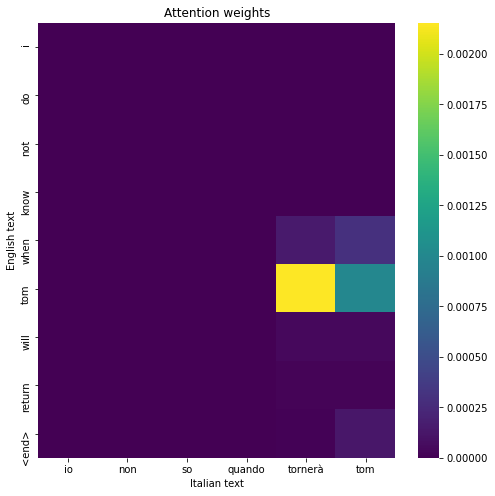

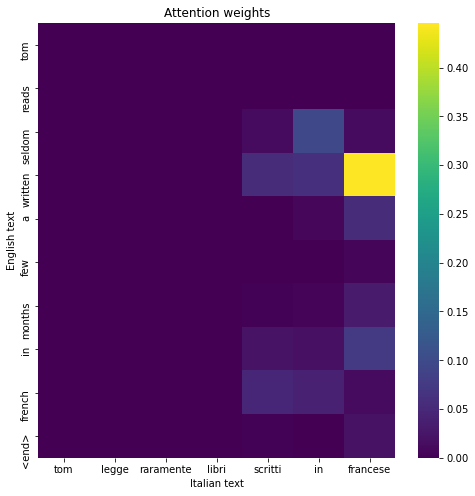

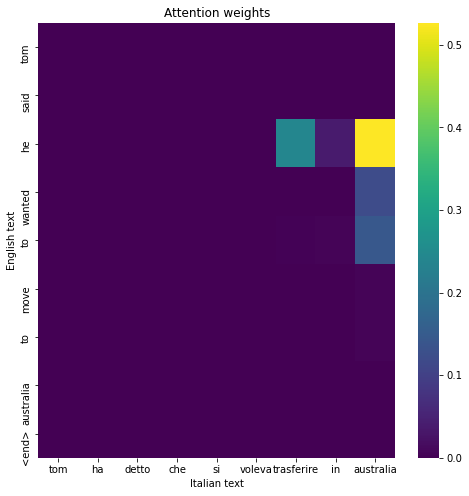

In [265]:
test_data_evaluation = validation.sample(3)
test_data_evaluation.reset_index(drop=True, inplace=True)

for i in range(3):
    predict(model_dot, test_data_evaluation['italian'][i], plot = True)

<font color='blue'>**Repeat the same steps for General scoring function**</font>

## Training using general scoring function

In [48]:
!rm -rf ./logs/enc-dec-general/

In [49]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [50]:
log_dir="logs/enc-dec-general/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
callbacks = [tensorboard_callback]

In [40]:
model_general  = encoder_decoder(vocab_size_ita = vocab_size_ita, vocab_size_eng = vocab_size_eng, embedding_dim = 300, 
                           encoder_inputs_length = 20, decoder_inputs_length = 20, lstm_units = 256,
                           score_fun = 'general' ,att_units = 256)

optimizer = tf.keras.optimizers.Adam()
model_general.compile(optimizer=optimizer,loss=loss_function)

In [41]:
model_general.fit(train_dataloader, validation_data = test_dataloader, steps_per_epoch = len(train_dataloader), 
          epochs = 15, callbacks = callbacks)

Epoch 1/15
1105/1105 [==============================] - 346s 310ms/step - loss: 1.5081 - val_loss: 1.0787
Epoch 2/15
1105/1105 [==============================] - 363s 329ms/step - loss: 0.8066 - val_loss: 0.5993
Epoch 3/15
1105/1105 [==============================] - 367s 332ms/step - loss: 0.4541 - val_loss: 0.3790
Epoch 4/15
1105/1105 [==============================] - 367s 332ms/step - loss: 0.2858 - val_loss: 0.2830
Epoch 5/15
1105/1105 [==============================] - 367s 332ms/step - loss: 0.2014 - val_loss: 0.2344
Epoch 6/15
1105/1105 [==============================] - 368s 333ms/step - loss: 0.1527 - val_loss: 0.2080
Epoch 7/15
1105/1105 [==============================] - 368s 333ms/step - loss: 0.1207 - val_loss: 0.1930
Epoch 8/15
1105/1105 [==============================] - 366s 331ms/step - loss: 0.1008 - val_loss: 0.1846
Epoch 9/15
1105/1105 [==============================] - 376s 340ms/step - loss: 0.0847 - val_loss: 0.1749
Epoch 10/15
1105/1105 [=======================

In [42]:
model_general.save_weights('model_general')

In [43]:
model_general.summary()

Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  8558468   
_________________________________________________________________
decoder_3 (Decoder)          multiple                  8168825   
_________________________________________________________________
dense_30 (Dense)             multiple                  0 (unused)
Total params: 16,727,293
Trainable params: 16,727,293
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%tensorboard --logdir="C:\Users\paart\seq2seq\logs\enc-dec-general\20220817-204213"

In [45]:
sample_test_evaluation(model_general)

italian sentence:  potrebbe aiutarci dopo la scuola
english_out sentence:  could you help us after school <end>
predicted english_out sentence:  could you help us after school <end>
----------------------------------------------------------------------------------------------------
italian sentence:  a voi serve il libro
english_out sentence:  do you need the book <end>
predicted english_out sentence:  do you need the book <end>
----------------------------------------------------------------------------------------------------
italian sentence:  io sono solo un messaggero
english_out sentence:  i am just a messenger <end>
predicted english_out sentence:  i am just a messenger <end>
----------------------------------------------------------------------------------------------------
italian sentence:  io ho sempre abitato a boston
english_out sentence:  i have always lived in boston <end>
predicted english_out sentence:  i have always lived in boston <end>
------------------------------

In [46]:
bleu_score(model_general)

bleu_score for 1000 sentences 0.7181298242903095


In [ ]:
## Attention plot using model_general for random 3 samples

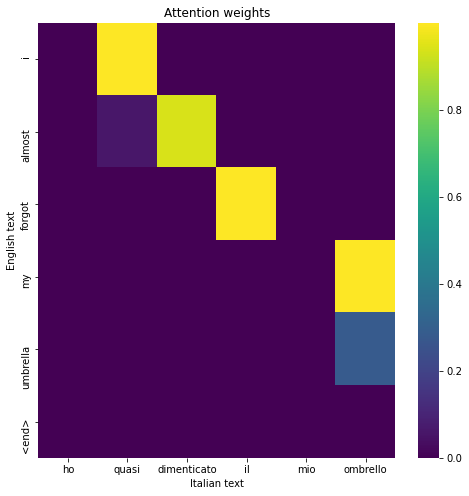

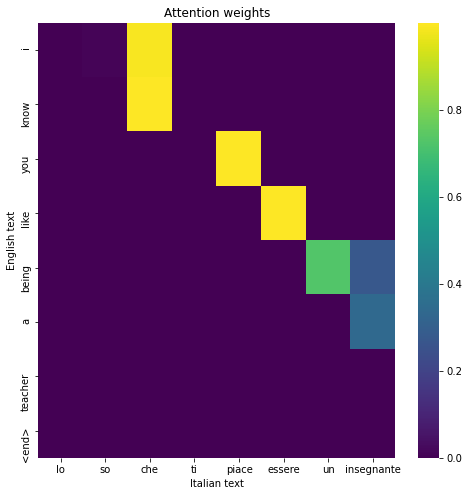

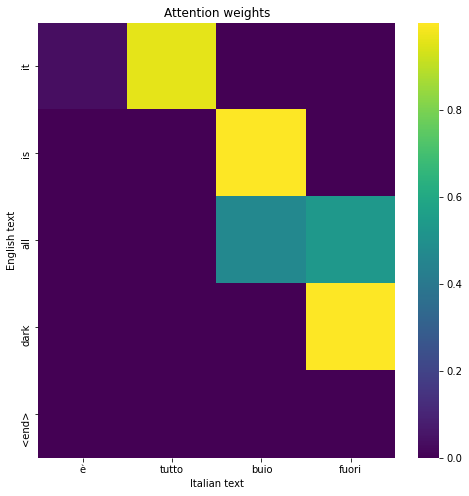

In [47]:
test_data_evaluation = validation.sample(3)
test_data_evaluation.reset_index(drop=True, inplace=True)

for i in range(3):
    predict(model_general, test_data_evaluation['italian'][i], plot = True)

<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

## Training using concat scoring function

In [33]:
!rm -rf ./logs/enc-dec-concat/

In [34]:
%load_ext tensorboard

In [35]:
log_dir="logs/enc-dec-concat/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
callbacks = [tensorboard_callback]

In [36]:
model_concat  = encoder_decoder(vocab_size_ita = vocab_size_ita, vocab_size_eng = vocab_size_eng, embedding_dim = 300, 
                           encoder_inputs_length = 20, decoder_inputs_length = 20, lstm_units = 256,
                           score_fun = 'concat' ,att_units = 256)

optimizer = tf.keras.optimizers.Adam()
model_concat.compile(optimizer=optimizer,loss=loss_function)

In [37]:
model_concat.fit(train_dataloader, validation_data = test_dataloader, steps_per_epoch = len(train_dataloader), 
          epochs = 10, callbacks = callbacks)

Epoch 1/10
1105/1105 [==============================] - 377s 338ms/step - loss: 1.4327 - val_loss: 0.9802
Epoch 2/10
1105/1105 [==============================] - 392s 355ms/step - loss: 0.7282 - val_loss: 0.5353
Epoch 3/10
1105/1105 [==============================] - 395s 357ms/step - loss: 0.3955 - val_loss: 0.3346
Epoch 4/10
1105/1105 [==============================] - 396s 359ms/step - loss: 0.2455 - val_loss: 0.2539
Epoch 5/10
1105/1105 [==============================] - 419s 380ms/step - loss: 0.1720 - val_loss: 0.2155
Epoch 6/10
1105/1105 [==============================] - 405s 367ms/step - loss: 0.1301 - val_loss: 0.1931
Epoch 7/10
1105/1105 [==============================] - 446s 404ms/step - loss: 0.1027 - val_loss: 0.1797
Epoch 8/10
1105/1105 [==============================] - 399s 361ms/step - loss: 0.0838 - val_loss: 0.1719
Epoch 9/10
1105/1105 [==============================] - 396s 359ms/step - loss: 0.0702 - val_loss: 0.1665
Epoch 10/10
1105/1105 [=======================

In [38]:
model_concat.save_weights('model_concat')

In [39]:
model_concat.summary()

Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  8565668   
_________________________________________________________________
decoder_3 (Decoder)          multiple                  8253255   
_________________________________________________________________
dense_22 (Dense)             multiple                  0 (unused)
Total params: 16,818,923
Trainable params: 16,818,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%tensorboard --logdir="C:\Users\paart\seq2seq\logs\enc-dec-concat\20220818-145357"

In [41]:
sample_test_evaluation(model_concat)

italian sentence:  tutti sono impazziti
english_out sentence:  everyone has gone mad <end>
predicted english_out sentence:  everybody is gone <end>
----------------------------------------------------------------------------------------------------
italian sentence:  sono spaventate
english_out sentence:  they are scared <end>
predicted english_out sentence:  they are scared <end>
----------------------------------------------------------------------------------------------------
italian sentence:  faccia bollire lacqua
english_out sentence:  boil the water <end>
predicted english_out sentence:  bring the water to a boil <end>
----------------------------------------------------------------------------------------------------
italian sentence:  noi lavoriamo tutte troppo duramente
english_out sentence:  we all work too hard <end>
predicted english_out sentence:  we all work too hard <end>
--------------------------------------------------------------------------------------------------

In [47]:
bleu_score(model_concat)

bleu_score for 1000 sentences 0.7058583941803541


## Attention plot using model_concat for random 3 samples

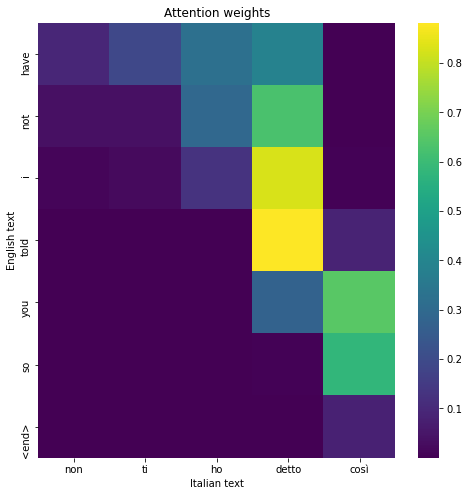

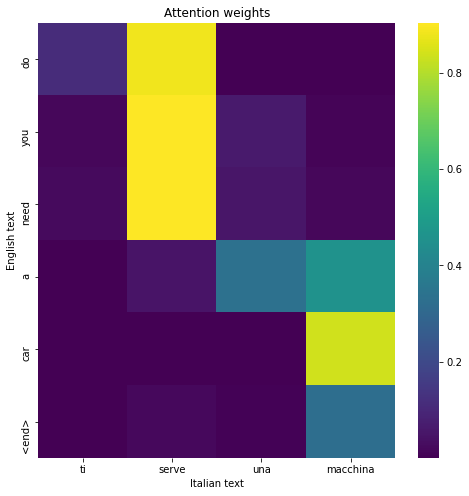

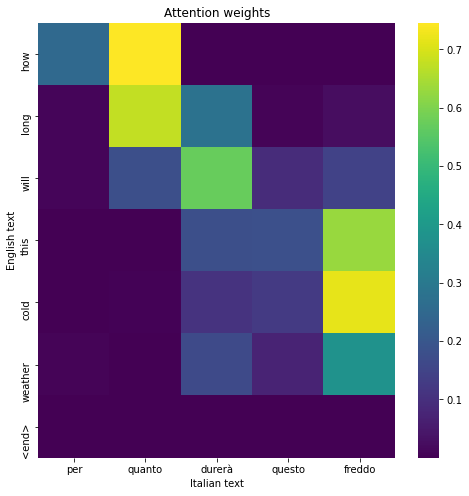

In [45]:
test_data_evaluation = validation.sample(3)
test_data_evaluation.reset_index(drop=True, inplace=True)

for i in range(3):
    predict(model_concat, test_data_evaluation['italian'][i], plot = True)

## summary

### 1. Custom Encoder Decoder Model

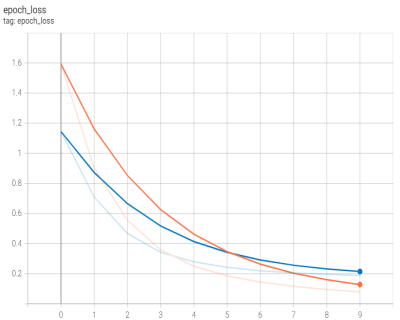

<br>

Achieved BLEU score of `0.6311824906323379`

### Models using Attention mechanism

### 2. Encoder Decoder using Dot scoring function

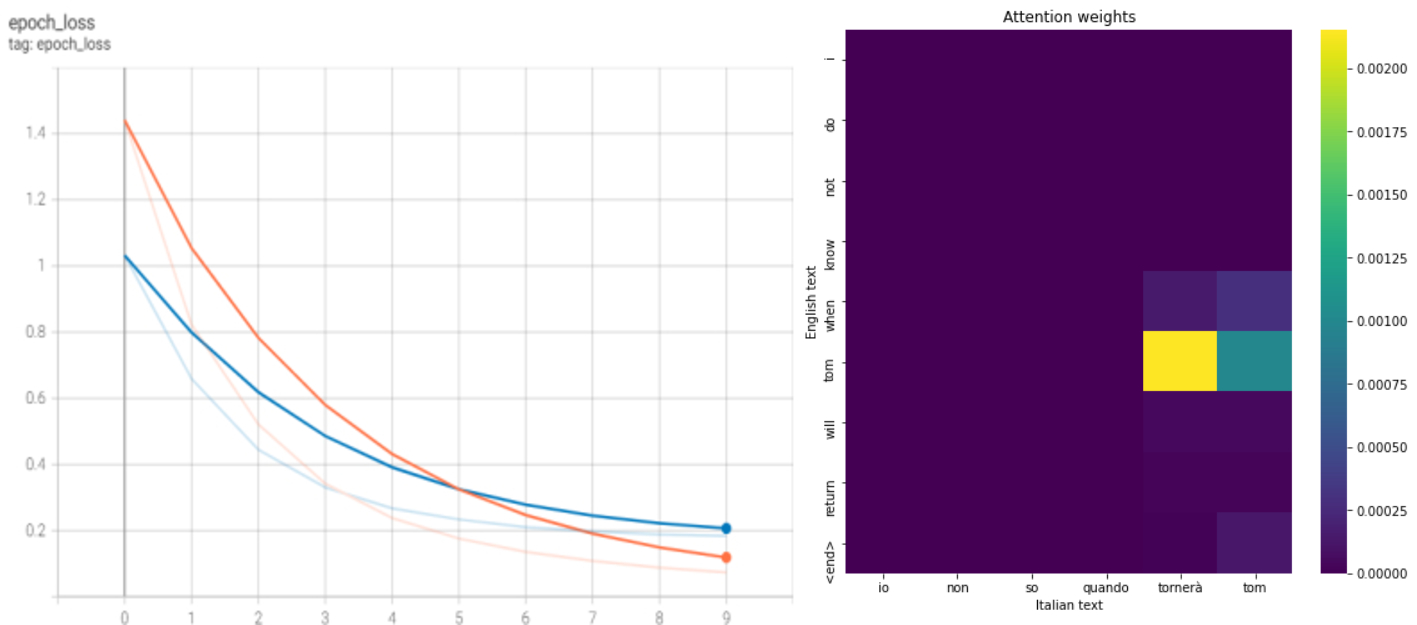

<br>

Achieved BLEU score of `0.6838457661785046`
- We can see a good improvement in performance compared to above model 
- in attention plot we can see it is not able to properly give attention in input sentences

### 3. Encoder Decoder using General scoring function

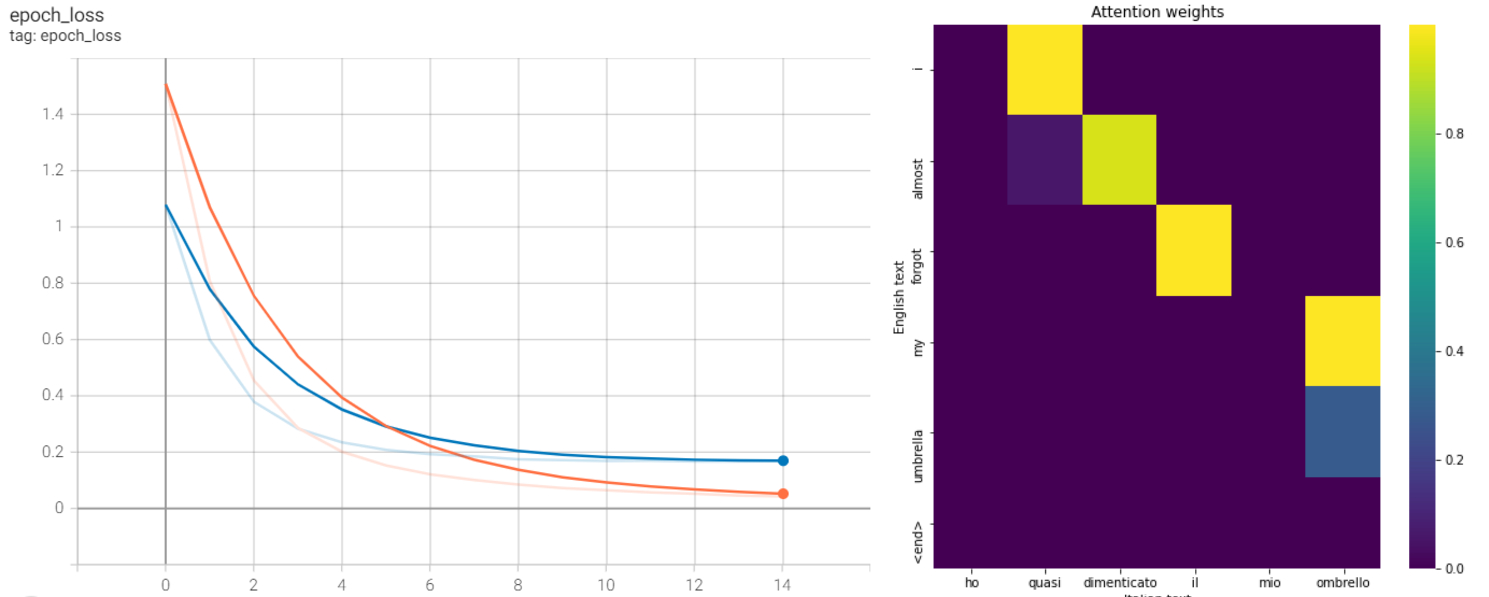

<br>

Achieved BLEU score of `0.7181298242903095`
- training is better as we can see loss is better that above model
- We can see a good improvement in performance compared to model using dot score function

### 4. Encoder Decoder using Concat scoring function

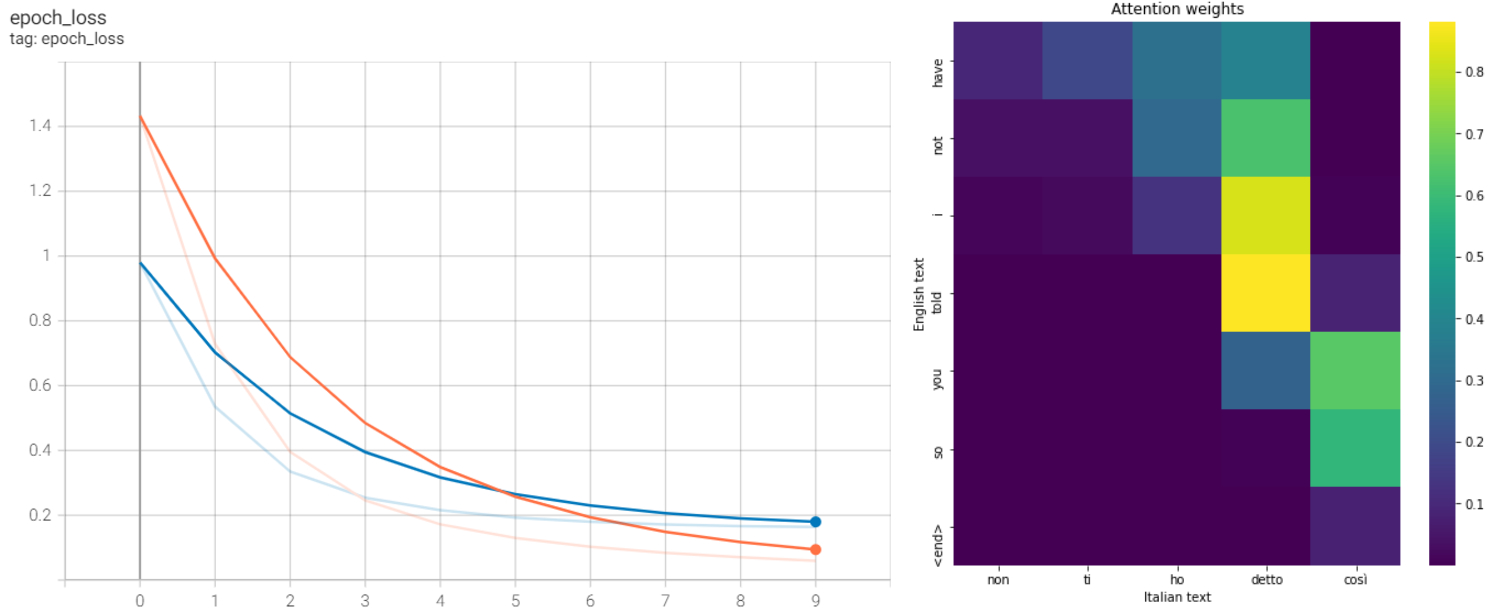

<br>

Achieved BLEU score of `0.7058583941803541`
- We can see almost same performance compared to model using general score function
- but here we can see in attention plot more attention is given to most of input sentences while translating which is better compared to other models
- predicted sentences are more closer to actual sentences using attention mechanism